# Questão 5

Para este exercício, foi implementada uma extração de features com o vetorizador de textos TfidfVectorizer e para o classificador foi ultiliada uma LGBM. Tanto o vetorizador quanto o classificador tiveram seus parâmetros tunados com o 
scikit-optimize.

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

from skopt import forest_minimize

from lightgbm import LGBMClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_auc_score, average_precision_score

from sklearn.metrics import plot_confusion_matrix

In [2]:
df = pd.read_excel('../data/teste_smarkio_lbs.xls', sheet_name='NLP')

In [3]:
df.head()

,letra,artista
0,Jay-z Uh-uh-uh You ready b? Let's go get 'em. ...,Beyoncé
1,Your challengers are a young group from Housto...,Beyoncé
2,"Dum-da-de-da Do, do, do, do, do, do (Coming do...",Beyoncé
3,If I ain't got nothing I got you If I ain't go...,Beyoncé
4,Six inch heels She walked in the club like nob...,Beyoncé


In [4]:
df.artista.unique()

array(['Beyoncé', 'Rihanna'], dtype=object)

Como temos somente duas classes, os artistas foram substituidos por 0 ('Beyoncé') e 1 ('Rihanna').

In [5]:
df.artista = df.artista.apply(lambda x: 0 if x == 'Beyoncé' else 1)

O dataset foi então dividido em treino e validação, com 33% do dataset para teste.

In [6]:
df_train, df_test, ytrain, ytest = train_test_split(df.letra, df.artista, test_size=0.2, random_state=42)

X = df_train
y = ytrain

Em seguida foi implementado um modelo Naive Bayes simples, para ser usado como baseline.

In [7]:
from sklearn.naive_bayes import GaussianNB

letra_vec = TfidfVectorizer()
letra_bow_train = letra_vec.fit_transform(df_train)
letra_bow_val = letra_vec.transform(df_test)

mdl_nb = GaussianNB()

mdl_nb.fit(letra_bow_train.toarray(), ytrain)

p_nb = mdl_nb.predict_proba(letra_bow_val.toarray())[:, 1]

In [8]:
average_precision_score(ytest, p_nb), roc_auc_score(ytest, p_nb)

(0.528657616892911, 0.5643729189789123)

Com o Naive Bayes avaliado, o próximo passo foi implementar a função de tune dos parâmetros e executar classificador proposto.

In [9]:
def tune_lgbm(params):
    print(params)
    lr = params[0]
    max_depth = params[1]
    min_child_samples = params[2]
    subsample = params[3]
    colsample_bytree = params[4]
    n_estimators = params[5]
    
    min_df = params[6]
    ngram_range = (1, params[7])
    
    average = []
    
    for (train, val) in KFold(5).split(X, y):
        X_train, X_val = X.iloc[train], X.iloc[val]
        y_train, y_val = y.iloc[train], y.iloc[val]
    
        letra_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
        letra_bow_train = letra_vec.fit_transform(X_train)
        letra_bow_val = letra_vec.transform(X_val)
    
        mdl = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, 
                         min_child_samples=min_child_samples, subsample=subsample,
                         colsample_bytree=colsample_bytree, n_estimators=n_estimators, random_state=0, 
                         class_weight="balanced", n_jobs=6)
    
        mdl.fit(letra_bow_train, y_train)

        p = mdl.predict_proba(letra_bow_val)[:, 1]
    
        average.append(-average_precision_score(y_val, p))
    
    return np.mean(average)


space = [(1e-3, 1e-1, 'log-uniform'), # lr
          (1, 10), # max_depth
          (1, 20), # min_child_samples
          (0.05, 1.), # subsample
          (0.05, 1.), # colsample_bytree
          (100,1000), # n_estimators
          (1,5), # min_df
          (1,5)] # ngram_range

res = forest_minimize(tune_lgbm, space, random_state=160745, n_random_starts=20, n_calls=50, verbose=1)

Iteration No: 1 started. Evaluating function at random point.
[0.009944912110647982, 5, 1, 0.4677107511929402, 0.49263223036174764, 272, 3, 1]
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.3330
Function value obtained: -0.7480
Current minimum: -0.7480
Iteration No: 2 started. Evaluating function at random point.
[0.053887464791860025, 1, 15, 0.7437489153990157, 0.8675167974293533, 549, 3, 4]
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 5.1339
Function value obtained: -0.7578
Current minimum: -0.7578
Iteration No: 3 started. Evaluating function at random point.
[0.004151454520895999, 6, 20, 0.8682075103820793, 0.9491436163200662, 411, 4, 3]
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 4.0346
Function value obtained: -0.7650
Current minimum: -0.7650
Iteration No: 4 started. Evaluating function at random point.
[0.0014099928811969545, 9, 9, 0.6502182010234373, 0.6866210554187129, 828, 5, 2]
Iteration No: 4 ended. Evalua

Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 3.0050
Function value obtained: -0.7601
Current minimum: -0.7926
Iteration No: 31 started. Searching for the next optimal point.
[0.006917152621544271, 10, 13, 0.2638264040251437, 0.516738006247261, 192, 1, 4]
Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 8.6987
Function value obtained: -0.7766
Current minimum: -0.7926
Iteration No: 32 started. Searching for the next optimal point.
[0.00490070620162511, 10, 11, 0.15438068838870028, 0.19601658148691992, 170, 5, 1]
Iteration No: 32 ended. Search finished for the next optimal point.
Time taken: 1.8082
Function value obtained: -0.7487
Current minimum: -0.7926
Iteration No: 33 started. Searching for the next optimal point.
[0.0035147112822723975, 10, 6, 0.2511365985246428, 0.5489751927269599, 645, 1, 4]
Iteration No: 33 ended. Search finished for the next optimal point.
Time taken: 16.2775
Function value obtained: -0.7778
Curren

Com os parâmetros otimizados, o classificador foi treinado e avaliado.

In [10]:
params = res.x
lr = params[0]
max_depth = params[1]
min_child_samples = params[2]
subsample = params[3]
colsample_bytree = params[4]
n_estimators = params[5]

min_df = params[6]
ngram_range = (1, params[7])

letra_vec = TfidfVectorizer(min_df=min_df, ngram_range=ngram_range)
letra_bow_train = letra_vec.fit_transform(df_train)
letra_bow_val = letra_vec.transform(df_test)

mdl_lgbm = LGBMClassifier(learning_rate=lr, num_leaves=2 ** max_depth, max_depth=max_depth, 
                     min_child_samples=min_child_samples, subsample=subsample,
                     colsample_bytree=colsample_bytree, n_estimators=n_estimators, random_state=0, 
                     class_weight="balanced", n_jobs=6)
mdl_lgbm.fit(letra_bow_train, ytrain)

p_lgbm = mdl_lgbm.predict_proba(letra_bow_val)[:, 1]

In [11]:
average_precision_score(ytest, p_lgbm), roc_auc_score(ytest, p_lgbm)

(0.8033082763989248, 0.8305586385497595)

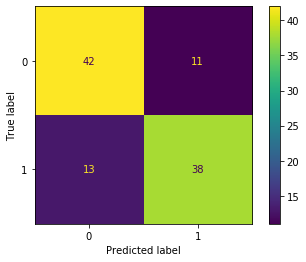

In [12]:
plot_confusion_matrix(mdl_lgbm, letra_bow_val, ytest)

Os resultados obtidos pela lgbm se mostrou bem superior aos do modelo Naive Bayes.

### Salvar os Modelos

In [13]:
import joblib as jb

In [14]:
jb.dump(mdl_lgbm, "../model/lgbm_model.pkl.z")
jb.dump(letra_vec, "../model/letra_vectorizer.pkl.z")

['../model/letra_vectorizer.pkl.z']